**First Description** 
--
**Task**: Restoring damaged images using an *Autoencoder*.\
**Data**: [Columbia Object Image Library (COIL-100) Dataset](https://www.kaggle.com/jessicali9530/coil100)\
The data is mainly pictures of random objects from different angles. We'll create another dataset by create a white squares on random positions.


**Downloading COIL-100 dataset from Kaggle**
---

In [0]:
from google.colab import files
!pip install -q kaggle
files.upload()

In [0]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json  

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!kaggle datasets download -d jessicali9530/coil100

 95% 121M/127M [00:01<00:00, 83.7MB/s]
100% 127M/127M [00:01<00:00, 114MB/s] 


In [0]:
! mkdir coil100 
! unzip coil100.zip -d /content/coil100

**Create damaged images**
---
A white square will be created on the images of the COIL-100 Dataset

In [0]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from skimage import color
from sklearn.model_selection import train_test_split
import random


def getData():
  original_images =[]
  destroyed_images= []
  for i in range(1,101):
    for j in range(0,360,5):
      path="/content/coil100/coil-100/coil-100/obj"+str(i)+"__"+str(j)+".png"
      org=image.load_img(path,target_size=(128,128,3))
      dst=image.load_img(path,target_size=(128,128,3))
      org=image.img_to_array(org)
      dst=image.img_to_array(dst)
      

      x=random.randint(0,88)
      y=random.randint(0,88) 
      for m in range (x, x+40 ,1):
        for n in range (y, y+40 ,1):
          dst[m][n]=[255., 255., 255.]

      dst=dst/255.
      destroyed_images.append(dst)
      org=org/255.
      original_images.append(org)


  Y=np.array(original_images)
  X=np.array(destroyed_images)
  return X,Y

In [0]:
X, Y= getData()

**Example of damaged images**
---

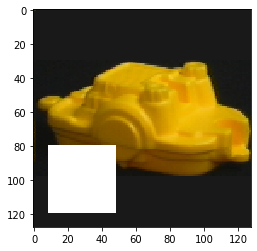

In [0]:
plt.imshow(X[150])

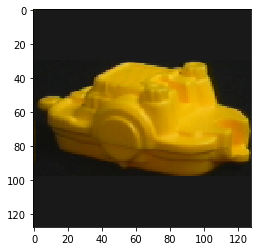

In [0]:
plt.imshow(Y[150])

**Train/Test Splitting**
---

In [0]:
Xtrain, Xtest, Ytrain, Ytest=train_test_split(X,Y,test_size=0.2, random_state=13)

**Architecture of the Autoencoder**
---

In [0]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D,MaxPooling2D, Conv2DTranspose, Flatten, UpSampling2D

In [0]:
inp = Input(shape=(128,128,3))

#encoder
x=(Conv2D(16,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same', input_shape=(128,128,3)))(inp)
#x=(Dropout(0.25))(x)
x=(Conv2D(32,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(x)
#x=(Dropout(0.25))(x)
#x=(Conv2D(64,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(x)
#x=(Dropout(0.25))(x)


#decoder
#x=(Conv2DTranspose(64,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(x)
#x=(Dropout(0.25))(x)
x=(Conv2DTranspose(32,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(x)
#x=(Dropout(0.25))(x)
x=(Conv2DTranspose(16,kernel_size=(5,5),activation='relu', strides=(2,2), padding='same'))(x)
#x=(Dropout(0.25))(x)
x=(Conv2DTranspose(3,kernel_size=(1,1),activation='relu', strides=(1,1), padding='same'))(x)

autoencoder = Model(inp,x)
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 16)        1216      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 32)        12832     
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 64, 64, 32)        25632     
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 128, 128, 16)      12816     
_________________________________________________________________
conv2d_transpose_35 (Conv2DT (None, 128, 128, 3)       51        
Total params: 52,547
Trainable params: 52,547
Non-trainable params: 0
_______________________________________________________

In [0]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

**Training**
---

In [0]:
autoencoder.fit(Xtrain,
                Ytrain,
                validation_data=(Xtest, Ytest),epochs=20,batch_size=128)

Train on 5760 samples, validate on 1440 samples
Epoch 1/20
5760/5760 [==============================] - 166s 29ms/step - loss: 0.5453 - val_loss: 0.5038
Epoch 2/20
5760/5760 [==============================] - 162s 28ms/step - loss: 0.4938 - val_loss: 0.4868
Epoch 3/20
5760/5760 [==============================] - 162s 28ms/step - loss: 0.4792 - val_loss: 0.4752
Epoch 4/20
5760/5760 [==============================] - 163s 28ms/step - loss: 0.4693 - val_loss: 0.4673
Epoch 5/20
5760/5760 [==============================] - 163s 28ms/step - loss: 0.4624 - val_loss: 0.4603
Epoch 6/20
5760/5760 [==============================] - 162s 28ms/step - loss: 0.4573 - val_loss: 0.4585
Epoch 7/20
5760/5760 [==============================] - 161s 28ms/step - loss: 0.4559 - val_loss: 0.4540
Epoch 8/20
5760/5760 [==============================] - 162s 28ms/step - loss: 0.4529 - val_loss: 0.4535
Epoch 9/20
5760/5760 [==============================] - 162s 28ms/step - loss: 0.4518 - val_loss: 0.4519
Epoch 1

**Results**
---

In [0]:
predicted = autoencoder.predict(Xtest)

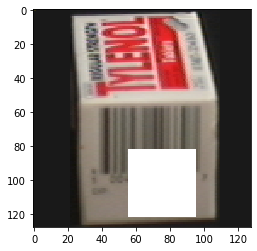

In [0]:
plt.imshow(Xtest[80])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


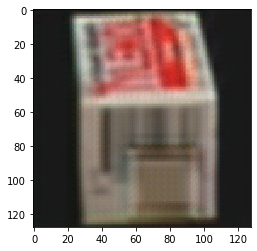

In [0]:
plt.imshow(predicted[80])


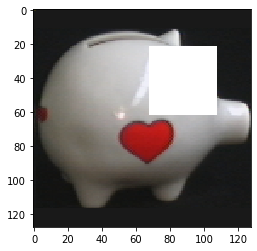

In [0]:
plt.imshow(Xtest[102])


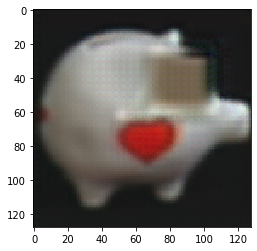

In [0]:
plt.imshow(predicted[102])